# Employee Sentiment Analysis

This notebook performs all required tasks:

1. Sentiment Labeling
2. Exploratory Data Analysis (EDA)
3. Employee Score Calculation
4. Employee Ranking
5. Flight Risk Identification
6. Predictive Modeling (excluding features based on positive/negative counts)

All steps include code, commentary, and visualizations.

## Task 1: Sentiment Labeling

- Load dataset (`test.xlsx`).
- Use TextBlob to label each message as Positive, Negative, or Neutral.
- Add `sentiment` and `score` columns.

In [21]:
import pandas as pd
from textblob import TextBlob

# Load the dataset
df = pd.read_excel('/content/test.xlsx')

# Rename columns if necessary
df = df.rename(columns={'from': 'employee_id', 'body': 'message'})

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sentiment labeling using TextBlob
df['polarity'] = df['message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def label_sentiment(p):
    if p > 0:
        return 'Positive'
    elif p < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(label_sentiment)
df['score'] = df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})

# Compute message length
df['message_length'] = df['message'].astype(str).str.len()

# Display first few rows
df[['employee_id', 'message', 'polarity', 'sentiment', 'score', 'message_length']].head()

,employee_id,message,polarity,sentiment,score,message_length
0,sally.beck@enron.com,EnronOptions Announcement\n\n\nWe have updated...,0.250,Positive,1,692
1,eric.bass@enron.com,"Marc,\n\nUnfortunately, today is not going to ...",-0.075,Negative,-1,315
2,sally.beck@enron.com,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",0.000,Neutral,0,150
3,johnny.palmer@enron.com,we were thinking papasitos (we can meet somewh...,-0.150,Negative,-1,155
4,lydia.delgado@enron.com,Since you never gave me the $20 for the last t...,-0.050,Negative,-1,197


## Task 2: Exploratory Data Analysis (EDA)

- Examine data structure, missing values.
- Distribution of sentiment labels.
- Trends over time.
- Additional patterns or anomalies.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overview of dataset
print("Number of records:", len(df))
print("Data types:\n", df.dtypes)
print("Missing values:\n", df.isnull().sum())

Number of records: 2191
Data types:
 Subject                   object
message                   object
date              datetime64[ns]
employee_id               object
polarity                 float64
sentiment                 object
score                      int64
message_length             int64
dtype: object
Missing values:
 Subject           0
message           0
date              0
employee_id       0
polarity          0
sentiment         0
score             0
message_length    0
dtype: int64


<ipython-input-23-f14e0e09f2ec>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')


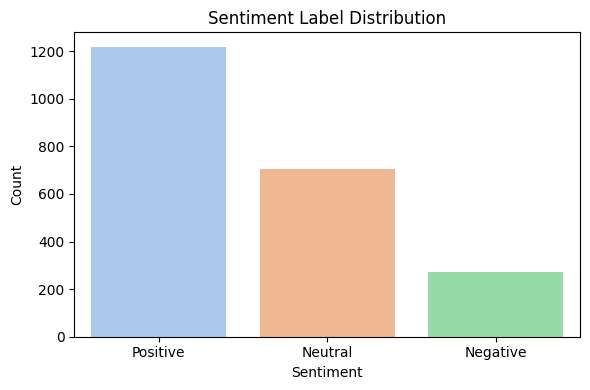

In [23]:
# Distribution of sentiment labels
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Sentiment Label Distribution.png')
plt.show()

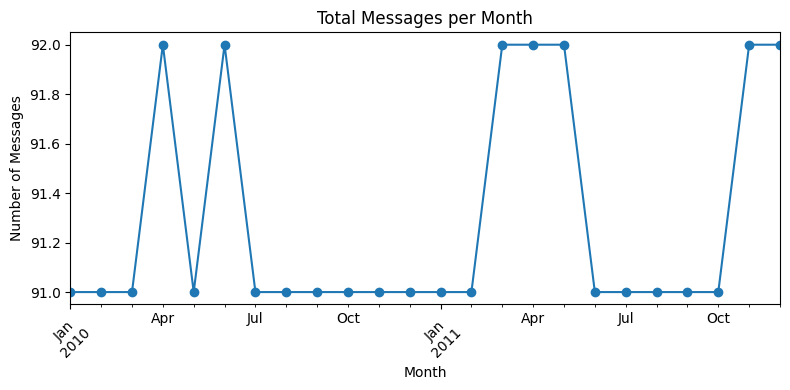

In [24]:
# Trend over time: Count of messages per month
df['year_month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size()

plt.figure(figsize=(8,4))
monthly_counts.plot(kind='line', marker='o')
plt.title('Total Messages per Month')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Count of messages per month.png')
plt.show()

<Figure size 800x500 with 0 Axes>

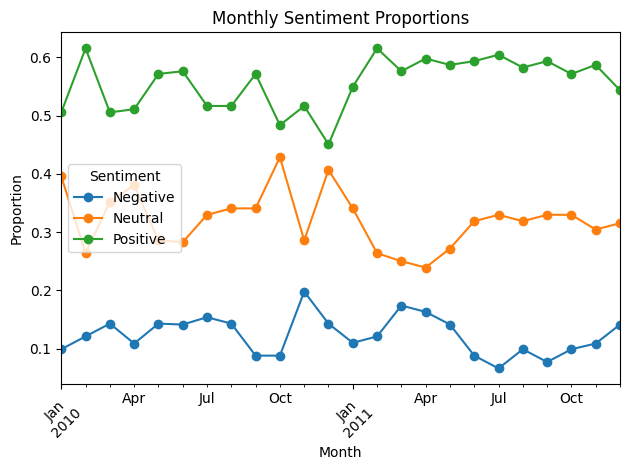

In [25]:
# Sentiment trend over time: proportion per month
monthly_sentiment = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
monthly_sentiment_pct = monthly_sentiment.div(monthly_sentiment.sum(axis=1), axis=0)

plt.figure(figsize=(8,5))
monthly_sentiment_pct.plot(kind='line', marker='o')
plt.title('Monthly Sentiment Proportions')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('Sentiment trend over time.png')
plt.show()

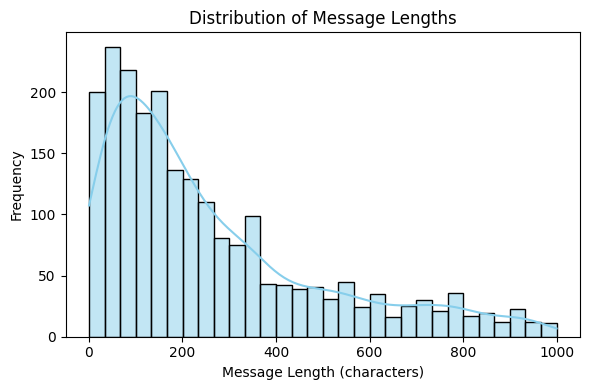

In [26]:
# Message length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['message_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('Distribution of Message Length.png')
plt.show()

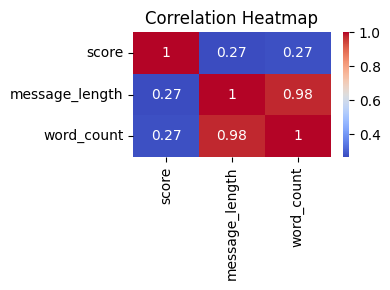

In [27]:
# Additional EDA: Correlation heatmap of numeric features
numeric_df = df[['score', 'message_length']].copy()
numeric_df['word_count'] = df['message'].astype(str).str.split().str.len()

corr = numeric_df.corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('Correlation Heatmap.png')
plt.show()

## Task 3: Employee Score Calculation

- Compute monthly sentiment score per employee: sum of scores (+1, 0, -1).
- Score resets each month.

In [28]:
# Calculate monthly sentiment score per employee
monthly_scores = df.groupby(['year_month', 'employee_id'])['score'].sum().reset_index(name='monthly_score')

# Display sample
monthly_scores.head()

,year_month,employee_id,monthly_score
0,2010-01,bobette.riner@ipgdirect.com,2
1,2010-01,don.baughman@enron.com,5
2,2010-01,eric.bass@enron.com,5
3,2010-01,john.arnold@enron.com,3
4,2010-01,johnny.palmer@enron.com,2


## Task 4: Employee Ranking

- Top 3 Positive Employees: highest scores each month.
- Top 3 Negative Employees: lowest scores each month.
- Sort by score (desc/asc) and then alphabetically.

In [29]:
# For each month, get top 3 positive and top 3 negative employees
def get_rankings(df_scores):
    all_periods = []
    for period in df_scores['year_month'].unique():
        period_data = df_scores[df_scores['year_month'] == period].copy()
        # Top 3 positive
        pos = period_data.sort_values(by=['monthly_score', 'employee_id'], ascending=[False, True]).head(3)
        pos['rank_type'] = 'Top Positive'
        # Top 3 negative
        neg = period_data.sort_values(by=['monthly_score', 'employee_id'], ascending=[True, True]).head(3)
        neg['rank_type'] = 'Top Negative'
        combined = pd.concat([pos, neg])
        combined['year_month'] = period
        all_periods.append(combined)
    return pd.concat(all_periods)

rankings_df = get_rankings(monthly_scores)
rankings_df

,year_month,employee_id,monthly_score,rank_type
5,2010-01,kayne.coulter@enron.com,9,Top Positive
1,2010-01,don.baughman@enron.com,5,Top Positive
2,2010-01,eric.bass@enron.com,5,Top Positive
8,2010-01,rhonda.denton@enron.com,0,Top Negative
0,2010-01,bobette.riner@ipgdirect.com,2,Top Negative
...,...,...,...,...
237,2011-12,patti.thompson@enron.com,6,Top Positive
235,2011-12,kayne.coulter@enron.com,5,Top Positive
230,2011-12,bobette.riner@ipgdirect.com,0,Top Negative
234,2011-12,johnny.palmer@enron.com,2,Top Negative


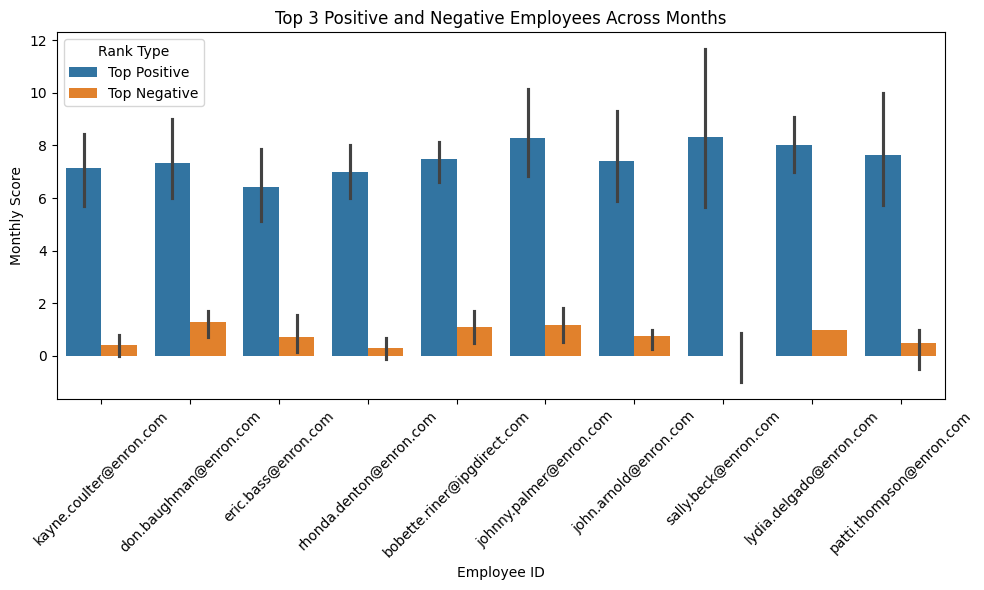

In [30]:
# Visualize rankings: bar plot of top positive and negative employees across months
plt.figure(figsize=(10,6))
sns.barplot(data=rankings_df, x='employee_id', y='monthly_score', hue='rank_type')
plt.title('Top 3 Positive and Negative Employees Across Months')
plt.xlabel('Employee ID')
plt.ylabel('Monthly Score')
plt.legend(title='Rank Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Top 3 Positive and Negative Employees Across Months.png')
plt.show()

## Task 5: Flight Risk Identification

- Identify employees who sent 4 or more negative messages in any rolling 30-day window.

In [31]:
neg_df = df[df['sentiment']=='Negative'].copy()
# Sort by employee_id and date so each group’s index is monotonic
neg_df = neg_df.sort_values(['employee_id', 'date']).set_index('date')

rolling_neg_counts = (
    neg_df
    .groupby('employee_id')['sentiment']
    .rolling('30D')
    .count()
    .reset_index(name='neg_count')
)

# Flag flight risk where neg_count >= 4
flight_risks = rolling_neg_counts[rolling_neg_counts['neg_count'] >= 4][['employee_id', 'date', 'neg_count']]

# Get unique employees and first flagged date
flight_risks_unique = flight_risks.groupby('employee_id')['date'].min().reset_index()
flight_risks_unique.rename(columns={'date': 'first_flagged_date'}, inplace=True)

# Display flight risk employees
flight_risks_unique

,employee_id,first_flagged_date
0,bobette.riner@ipgdirect.com,2010-11-17
1,don.baughman@enron.com,2010-03-07
2,eric.bass@enron.com,2010-04-15
3,john.arnold@enron.com,2010-06-18
4,johnny.palmer@enron.com,2010-02-26
5,lydia.delgado@enron.com,2010-11-25
6,patti.thompson@enron.com,2010-05-02
7,rhonda.denton@enron.com,2010-08-28
8,sally.beck@enron.com,2010-07-06


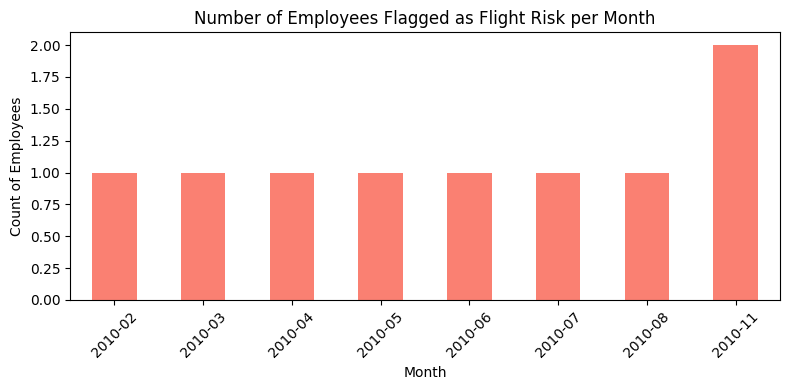

In [32]:
# Extract month for first flagged date
flight_risks_unique['first_flagged_month'] = flight_risks_unique['first_flagged_date'].dt.to_period('M')

# Count flight risks per month
flight_risk_counts = flight_risks_unique['first_flagged_month'].value_counts().sort_index()

plt.figure(figsize=(8,4))
flight_risk_counts.plot(kind='bar', color='salmon')
plt.title('Number of Employees Flagged as Flight Risk per Month')
plt.xlabel('Month')
plt.ylabel('Count of Employees')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Number of Employees Flagged as Flight Risk per Month.png')
plt.show()

## Task 6: Predictive Modeling

- Build a linear regression model to predict monthly sentiment scores.
- Exclude features based on positive/negative counts.
- Use features such as message frequency, average length, word count per month.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature engineering excluding pos/neg counts
features = df.groupby(['year_month', 'employee_id']).agg(
    message_count=('message', 'count'),
    avg_length=('message_length', 'mean'),
    avg_word_count=('message', lambda x: x.str.split().str.len().mean())
).reset_index()

# Merge features with monthly scores
model_data = features.merge(monthly_scores, on=['year_month', 'employee_id'])

# Define feature matrix X and target y
X = model_data[['message_count', 'avg_length', 'avg_word_count']]
y = model_data['monthly_score']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

In [34]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

# Display coefficients
coeff_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
})
display(coeff_df)

MSE: 4.206
R²: 0.641


,feature,coefficient
0,message_count,0.409717
1,avg_length,-0.005450
2,avg_word_count,0.050570


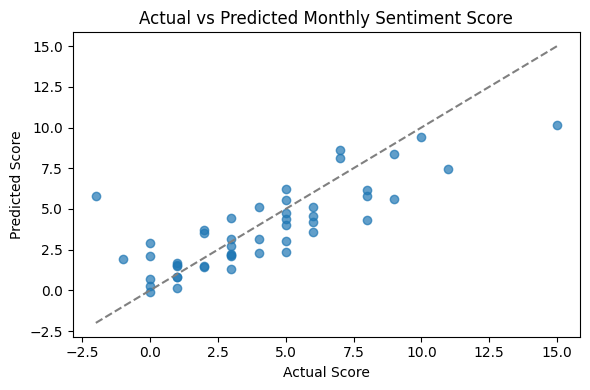

In [35]:
# Plot actual vs predicted sentiment scores
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.title('Actual vs Predicted Monthly Sentiment Score')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.tight_layout()
plt.savefig('Actual vs Predicted Monthly Sentiment Score.png')
plt.show()